# Psuedo Weight Pruning and Clustering
2017-05-10

### Model

In this post, we use a trained AlexNet model (training on ImageNet dataset). AlexNet has 8 parameterized layers: 5 convolutional and 4 fully connected:

1. `conv1`: 96 11x11-kernels - 3 channels
2. `conv2`: 256 5x5-kernels - 48 channels
3. `conv3`: 384 3x3-kernels - 256 channels
4. `conv4`: 384 3x3-kernels - 192 channels  
5. `conv5`: 256 3x3-kernels - 192 channels
6. `fc6`: 4096x9216 matrix
7. `fc7`: 4096x4096 matrix
8. `fc8`: 1000x4096 matrix

Each of these layers is saved as a numpy 2D array.

In [1]:
import numpy as np
import os
import sys

weights_path = '/'.join(os.getcwd().split('/')[:-1]) + '/local-trained/alexnet/weights/'
print(weights_path)

/home/gear/Dropbox/WorkingFiles/CREST-Deep-M/local-trained/alexnet/weights/


In [2]:
os.listdir(weights_path)

['fc7.npy',
 'fc8.npy',
 'conv5.npy',
 'fc6.npy',
 'conv2.npy',
 'conv1.npy',
 'conv3.npy',
 'conv4.npy']

In [3]:
keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
weights = {}
for k in keys:
    weights[k] = np.load(weights_path + k + '.npy')

The shape of each layers:

In [4]:
for k in keys:
    print("Layer " + k + ": " + str(weights[k].shape))

Layer conv1: (96, 3, 11, 11)
Layer conv2: (256, 48, 5, 5)
Layer conv3: (384, 256, 3, 3)
Layer conv4: (384, 192, 3, 3)
Layer conv5: (256, 192, 3, 3)
Layer fc6: (4096, 9216)
Layer fc7: (4096, 4096)
Layer fc8: (1000, 4096)


### Preprocessing

We analyze the statisical properties for each layers.

In [5]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Using `ggplot` (R style) for all the plots. There are 7 colors in the color wheel, we simply use a global variable `i` to cycle through all the color. Function `histogram` here plots to axis `ax`.

In [6]:
plt.style.use('ggplot')
i = 0
def histogram(ax, x, num_bins=1000):
    """Plot a histogram onto ax"""
    global i
    i = (i + 1) % 7
    clr = list(plt.rcParams['axes.prop_cycle'])[i]['color']
    return ax.hist(x, num_bins, normed=1, color=clr, alpha=0.8)

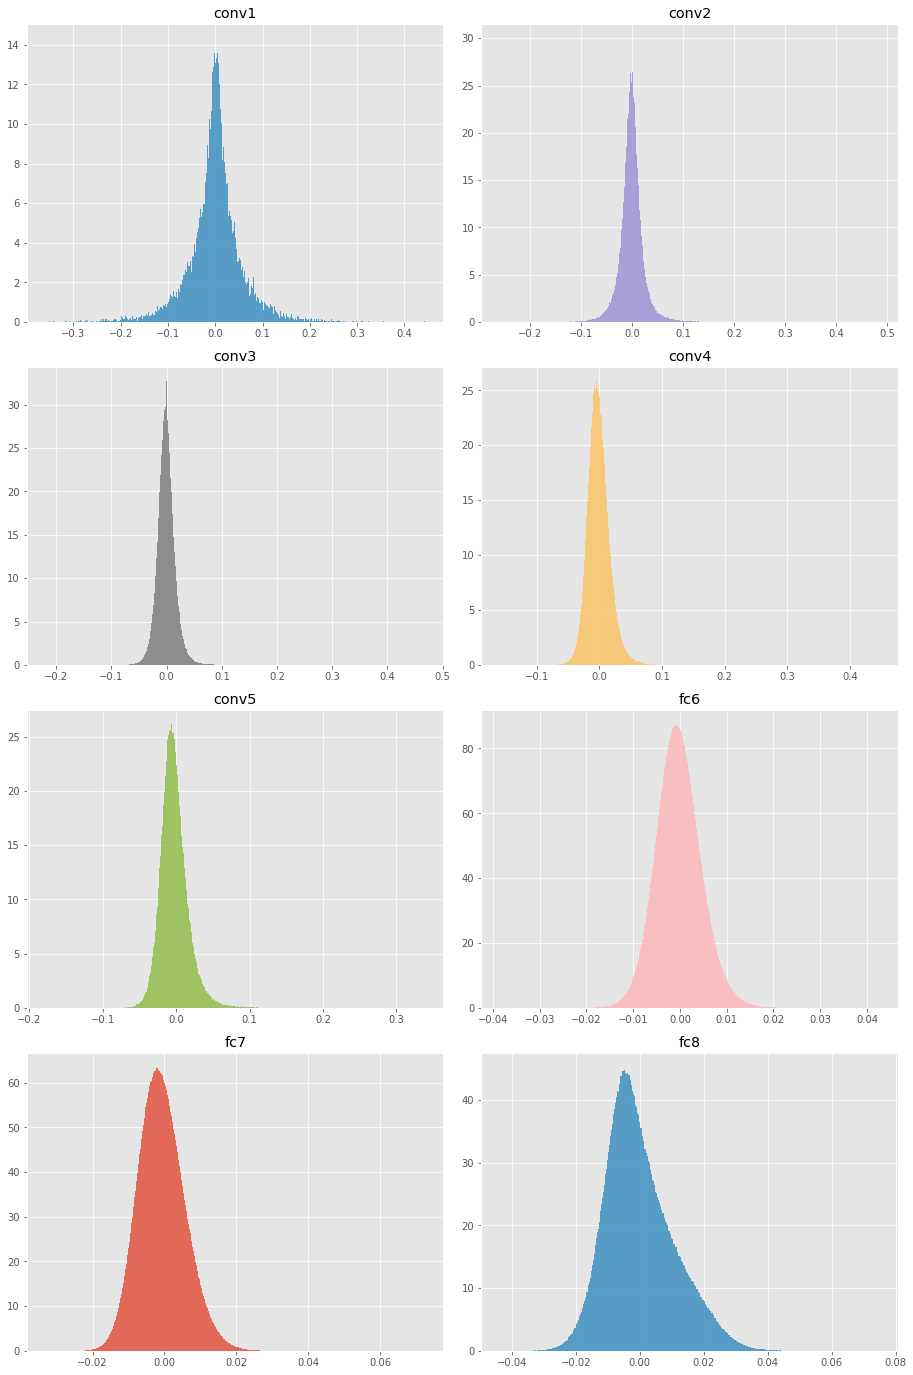

In [7]:
# Create figure and 8 axes (4-by-2)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12.8,19.2))

# Flatten each layer
conv1_f = weights['conv1'].flatten()
conv2_f = weights['conv2'].flatten() 
conv3_f = weights['conv3'].flatten()
conv4_f = weights['conv4'].flatten() 
conv5_f = weights['conv5'].flatten()
fc6_f = weights['fc6'].flatten()
fc7_f = weights['fc7'].flatten()
fc8_f = weights['fc8'].flatten()

# Plot histogram
histogram(ax[0,0], conv1_f)
ax[0,0].set_title("conv1")
histogram(ax[0,1], conv2_f)
ax[0,1].set_title("conv2")
histogram(ax[1,0], conv3_f)
ax[1,0].set_title("conv3")
histogram(ax[1,1], conv4_f)
ax[1,1].set_title("conv4")
histogram(ax[2,0], conv5_f)
ax[2,0].set_title("conv5")
histogram(ax[2,1], fc6_f)
ax[2,1].set_title("fc6")
histogram(ax[3,0], fc7_f)
ax[3,0].set_title("fc7")
histogram(ax[3,1], fc8_f)
ax[3,1].set_title("fc8")
fig.tight_layout()
plt.show()
plt.close()

The plot showed that all weights in AlexNet seems to have zero mean and follows a normal (or gamma) distribution. Next, we use violin plot to show the statistical properties of these weights in detail. 

In [8]:
def violin(ax, x, pos):
    """Plot a histogram onto ax"""
    ax.violinplot(x, showmeans=True, showextrema=True, showmedians=True, positions=[pos])

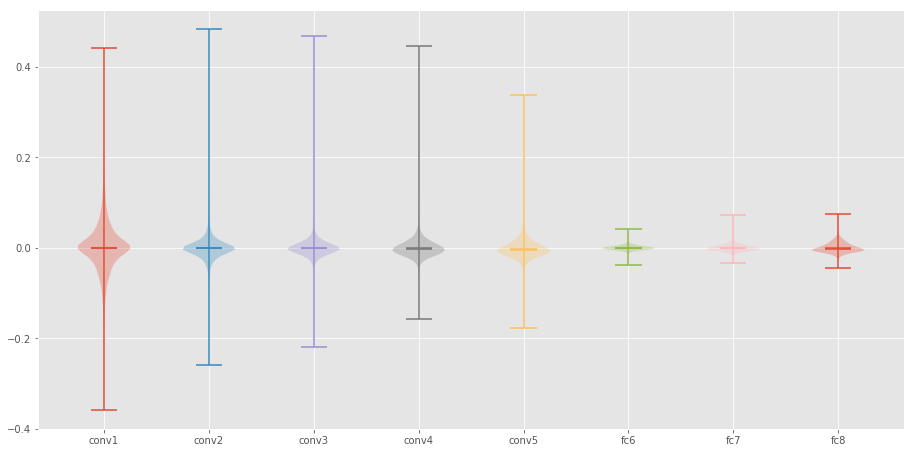

In [9]:
# Create a single figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12.8,6.4))

# Plot violin
violin(ax, conv1_f, pos=0)
violin(ax, conv2_f, pos=1)
violin(ax, conv3_f, pos=2)
violin(ax, conv4_f, pos=3)
violin(ax, conv5_f, pos=4)
violin(ax, fc6_f, pos=5)
violin(ax, fc7_f, pos=6)
violin(ax, fc8_f, pos=7)

# Labels
ax.set_xticks(np.arange(0, len(keys)))
ax.set_xticklabels(keys)

fig.tight_layout()
plt.show()
plt.close()

### Pruning

This session provide a simple pseudo pruning function. We call this pseudo pruning because these is no re-training involved, hence the accuracy of the neural network would greatly decreased comparing to the pruning-retraining scheme. The `prun` function here merely used to create a fake sparse matrix to use for testing the compression packing.

In [10]:
def prun(o_weights, thres=None, percentile=0.8):
    """Set weights to zero according the threshold.
    If the threshold is not provided, `thres` is 
    infered from `percentile`."""
    w_weights = o_weights.reshape(1,-1)
    if thres == None:
        args = w_weights[0].argsort()
        thres = w_weights[0][args[int((len(args)-1)*(1-percentile))]]
    for i, val in enumerate(w_weights[0]):
        if abs(val) <= thres:
            w_weights[0][i] = 0.0
            

Test the effect of pruning:

In [11]:
print("Before pruning:")
for layer_name in keys:    
    print(layer_name + " total size: " + str(weights[layer_name].size))
    print(layer_name + " non-zero count: " + str(np.count_nonzero(weights[layer_name])))
    print("Density: " + str(float(np.count_nonzero(weights[layer_name]))/weights[layer_name].size))

print("Cloning layers...")
clone_w = {}
for layer_name in keys:
    clone_w[layer_name] = weights[layer_name].copy()

keep_per = 0.3
print("Prunning... Keeping " + str(keep_per*100) + "%")
for layer_name in keys:
    prun(clone_w[layer_name], percentile=keep_per)
    print(layer_name + " total size: " + str(clone_w[layer_name].size))
    print(layer_name + " non-zero count: " + str(np.count_nonzero(clone_w[layer_name])))
    print("Density: " + str(float(np.count_nonzero(clone_w[layer_name])*1.0)/clone_w[layer_name].size))

Before pruning:
conv1 total size: 34848
conv1 non-zero count: 34848
Density: 1.0
conv2 total size: 307200
conv2 non-zero count: 307200
Density: 1.0
conv3 total size: 884736
conv3 non-zero count: 884736
Density: 1.0
conv4 total size: 663552
conv4 non-zero count: 663552
Density: 1.0
conv5 total size: 442368
conv5 non-zero count: 442368
Density: 1.0
fc6 total size: 37748736
fc6 non-zero count: 37748736
Density: 1.0
fc7 total size: 16777216
fc7 non-zero count: 16777216
Density: 1.0
fc8 total size: 4096000
fc8 non-zero count: 4096000
Density: 1.0
Cloning layers...
Prunning... Keeping 30.0%
conv1 total size: 34848
conv1 non-zero count: 20775
Density: 0.59616046832
conv2 total size: 307200
conv2 non-zero count: 204887
Density: 0.666949869792
conv3 total size: 884736
conv3 non-zero count: 595842
Density: 0.673468695747
conv4 total size: 663552
conv4 non-zero count: 471549
Density: 0.710643627025
conv5 total size: 442368
conv5 non-zero count: 356106
Density: 0.804999457465
fc6 total size: 37748

### Clustering

The next step after prunning is to cluster the weight values using k-means. For the convolutional layers `k=256`, and `k=16` for the fully connected layers. First, we run clustering for **un-prunned weight matrices**.

In [13]:
from sklearn.cluster import KMeans

In [16]:
def quantize_kmeans(weight, ncluster=256, rs=0):
    org_shape = weight.shape
    km = KMeans(n_clusters=ncluster, random_state=rs).fit(weight.reshape(-1,1))
    num_bits = int(np.ceil(np.log2(ncluster)))
    encoded = np.zeros_like(weight, dtype=np.int32)
    codebook = km.cluster_centers_
    weight = weight.reshape(1,-1)
    encoded = encoded.reshape(1,-1)
    for i in range(encoded.size):
        encoded[i] = km.predict(weight[i])
    return num_bits, encoded

In [15]:
print("Clustering conv1 ...")
conv1_k = KMeans(n_clusters=256, random_state=0).fit(weights['conv1'].reshape(-1,1))
print("Clustering conv2 ...")
conv2_k = KMeans(n_clusters=256, random_state=0).fit(weights['conv2'].reshape(-1,1))
print("Clustering conv3 ...")
conv3_k = KMeans(n_clusters=256, random_state=0).fit(weights['conv3'].reshape(-1,1))
print("Clustering conv4 ...")
conv4_k = KMeans(n_clusters=256, random_state=0).fit(weights['conv4'].reshape(-1,1))
print("Clustering conv5 ...")
conv5_k = KMeans(n_clusters=256, random_state=0).fit(weights['conv5'].reshape(-1,1))
print("Clustering fc6 ...")
fc6_k = KMeans(n_clusters=16, random_state=0).fit(weights['fc6'].reshape(-1,1))
print("Clustering fc7 ...")
fc7_k = KMeans(n_clusters=16, random_state=0).fit(weights['fc7'].reshape(-1,1))
print("Clustering fc8 ...")
fc8_k = KMeans(n_clusters=16, random_state=0).fit(weights['fc8'].reshape(-1,1))

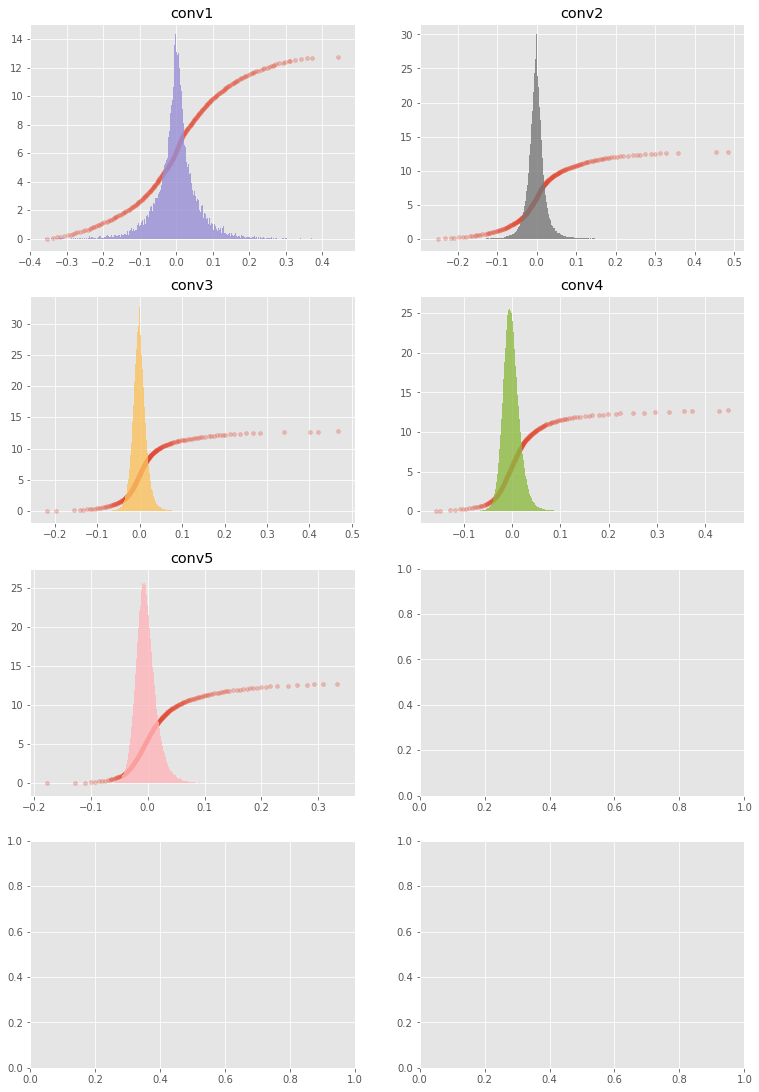

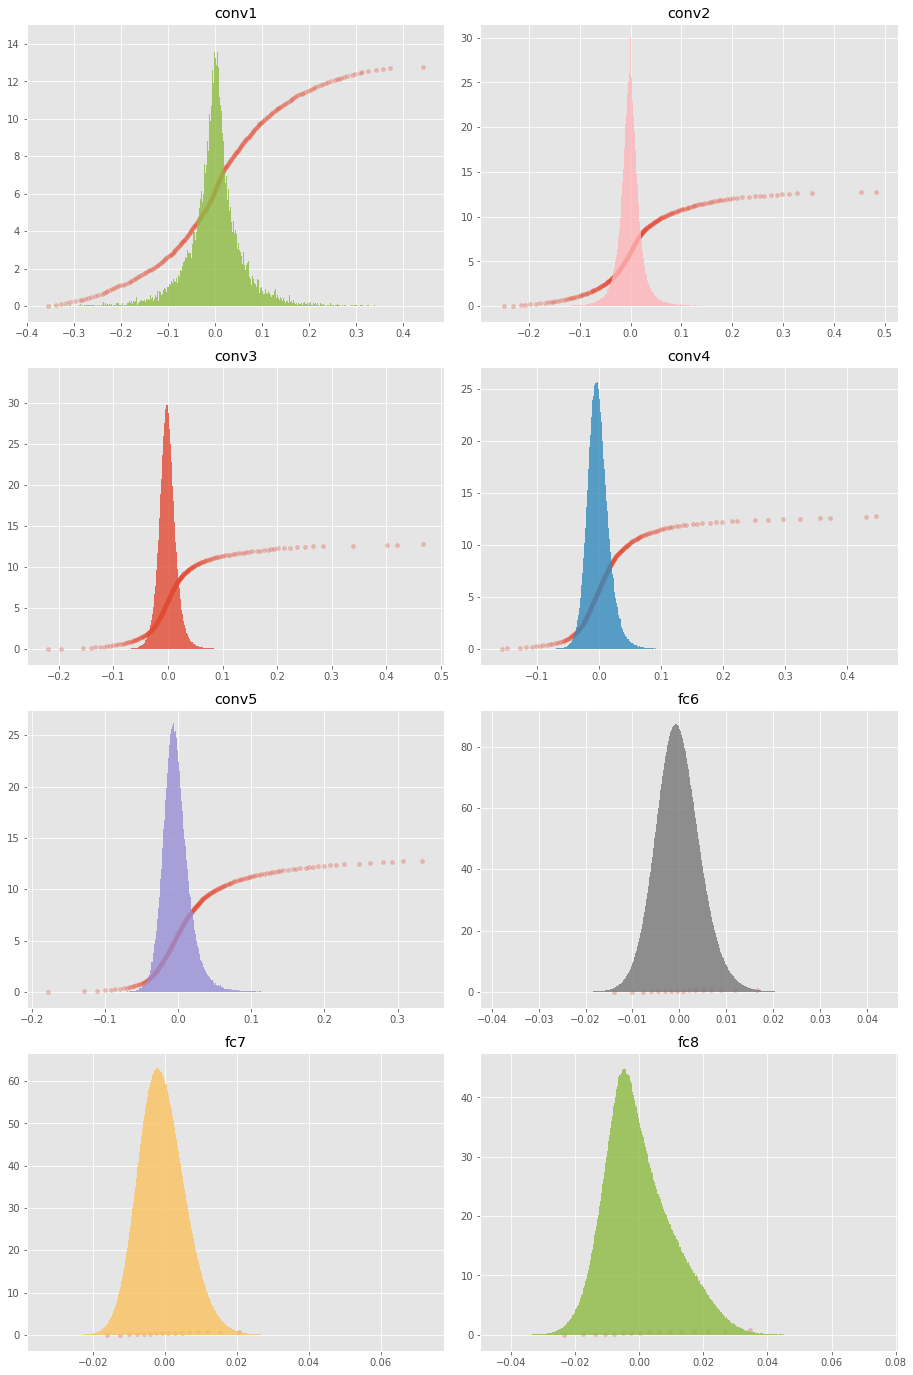

In [19]:
def histogram_kmeans(ax, flat, kmeans, norm=20):
    histogram(ax, flat)
    tmp = np.ones_like(kmeans.cluster_centers_)
    idx = ((np.cumsum(tmp)) - 1) / norm
    ax.scatter(sorted(kmeans.cluster_centers_), idx, s=16, alpha=0.3)

plt.close()
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12.8,19.2))

histogram_kmeans(ax[0,0], conv1_f, conv1_k)
ax[0,0].set_title("conv1")
histogram_kmeans(ax[0,1], conv2_f, conv2_k)
ax[0,1].set_title("conv2")
histogram_kmeans(ax[1,0], conv3_f, conv3_k)
ax[1,0].set_title("conv3")
histogram_kmeans(ax[1,1], conv4_f, conv4_k)
ax[1,1].set_title("conv4")
histogram_kmeans(ax[2,0], conv5_f, conv5_k)
ax[2,0].set_title("conv5")
histogram_kmeans(ax[2,1], fc6_f, fc6_k)
ax[2,1].set_title("fc6")
histogram_kmeans(ax[3,0], fc7_f, fc7_k)
ax[3,0].set_title("fc7")
histogram_kmeans(ax[3,1], fc8_f, fc8_k)
ax[3,1].set_title("fc8")
fig.tight_layout()


plt.show()
plt.close()

In [ ]:
la = p[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12.8, 6))
n, b, p = histogram(ax, conv1_f)
conv1_zero = np.ones_like(conv1_k.cluster_centers_)
conv1_ones = ((np.cumsum(conv1_zero)) - 1) / 20
ax.scatter(sorted(conv1_k.cluster_centers_), conv1_ones, s=16, alpha=0.3)
plt.show()
plt.close()

In [ ]:
la = sorted(conv1_k.cluster_centers_)

In [ ]:
la = conv1_k.cluster_centers_.copy()

In [ ]:
la.sort()

In [ ]:
la.shape

In [ ]:
conv1_zero.shape

In [ ]:
conv1_k.predict([[0.03],[0.004]])

In [ ]:
conv1_k.cluster_centers_[91]